# Illegal zoning
_they made the character of our neighboorhoods illegal_

Waltham, like a [lot](https://cityobservatory.org/the-illegal-city-of-somerville/) of [other](https://www.nytimes.com/interactive/2016/05/18/upshot/which-buildings-in-manhattan-couldnt-be-built-again-today.html) cities with zoning codes, has a bit of a silly problem.
You see, the zoning is so restrictive in some places, that the existing structures could not be rebuilt.
Everything would have to go through a special permit, which is time consuming and expensive. You can imagine a lot of people
wouldn't even bother and just build where the zoning is easier.

What's the scale of the problem?

In this notebook, I'll load GIS shapefiles data (some from MassGIS, some from the city) try to determine where Waltham has this issue. Some of these violations can only be confirmed by surveying,
so I'll only tackle the simpler ones here.

In [1]:

import pandas as pd
import folium
import os
import geopandas as geo_pd
import seaborn as sns

# data fetching
from data.connect_db import get_db

%matplotlib inline

# constants
from waltham.constants import SQ_FT_PER_ACRE, FT_PER_STORY, MASSGIS_CRS

ACRE_TO_M2 = 4046.86

con = get_db()


## Load shapefiles for buildings, zones, and parcels as well as the tax assessments data

In [2]:

query = """
select
    *
from
    "M308TaxPar_CY22_FY23"
"""

property_shapefiles_df = geo_pd.read_postgis(query, con)

# filter out right of way and water etc. property types
property_shapefiles_df = property_shapefiles_df[property_shapefiles_df["POLY_TYPE"] == "FEE"]
property_shapefiles_df = property_shapefiles_df[["LOC_ID", "geom", "SHAPE_Area"]]

property_shapefiles_df["SHAPE_Area"] = property_shapefiles_df["SHAPE_Area"] / ACRE_TO_M2

query = """
select
    *
from
    "M308Assess_CY22_FY23"
"""

assessments_df = pd.read_sql(query, con)
assessments_df = assessments_df[["LOC_ID", "SITE_ADDR", "YEAR_BUILT", "UNITS", "RES_AREA", "STORIES", "USE_CODE", "BLD_AREA"]]

### Data cleaning
See comments for reasoning

In [3]:

# bin YEAR_BUILT to 5 year intervals since this data was less accurate in the past
assessments_df["YEAR_BUILT"] = (assessments_df["YEAR_BUILT"] // 5).round().astype(int) * 5

# use codes should be ints, since they're grouped by hundreds typically
assessments_df["USE_CODE"] = assessments_df["USE_CODE"].astype(int)

# using 14 ft/story (TODO: find a reference for this value),
# and converting to meters for later QGIS use (CRS is in meters)
M_PER_FT = 0.3048
assessments_df["assumed_height"] = assessments_df["STORIES"].apply(lambda x: 0 if x is None else float(x)* FT_PER_STORY * M_PER_FT)

In [4]:
assessments_df.head()

LOC_ID        SITE_ADDR  YEAR_BUILT  UNITS  RES_AREA STORIES  \
0  F_734012_2963106  31  CLEMENTS RD        1930      1      1352       2   
1  F_730830_2973583     4  ABBOTT RD        1960      1      1931       1   
2  F_730659_2973534    15  ABBOTT RD        1950      1      1756       2   
3  F_730718_2973342    22  ABBOTT RD        1950      1      2922       2   
4  F_730548_2973294    33  ABBOTT RD        1950      1      1792       2   

   USE_CODE  BLD_AREA  assumed_height  
0       101      1352          8.5344  
1       101      1931          4.2672  
2       101      1756          8.5344  
3       101      2922          8.5344  
4       101      1792          8.5344

In [5]:
property_shapefiles_df.head()

LOC_ID                                               geom  \
0  F_720118_2954451  MULTIPOLYGON (((219510.406 900516.563, 219505....   
1  F_720144_2954524  MULTIPOLYGON (((219521.229 900544.743, 219512....   
2  F_722474_2954539  MULTIPOLYGON (((220212.276 900527.633, 220199....   
3  F_720055_2954540  MULTIPOLYGON (((219481.807 900560.359, 219483....   
4  F_720183_2954604  MULTIPOLYGON (((219530.434 900568.770, 219524....   

   SHAPE_Area  
0    0.103024  
1    0.216257  
2    0.102640  
3    0.265953  
4    0.152051

In [6]:
query = """
select
    *
from
    "Buildings"
"""
buildings_df = geo_pd.read_postgis(query, con)
buildings_df = buildings_df[["geom"]]

buildings_df.head()

geom
0  MULTIPOLYGON (((219179.561 908215.757, 219174....
1  MULTIPOLYGON (((219207.717 908210.616, 219205....
2  MULTIPOLYGON (((219181.783 908206.625, 219176....
3  MULTIPOLYGON (((219192.485 908186.819, 219192....
4  MULTIPOLYGON (((219235.340 908191.010, 219235....

## The zoning rules table

This data comes from `Sec. 4.11. Table of Dimensional Regulations` of the city zoning code.

https://ecode360.com/attachment/WA1697/WA1697-Ze%20Table%20of%20Dimentional%20Regulations.pdf

I selected rows that apply to multi-family housing when the table had a more complex case defined per-use type.

Units are in feet for the most part, except for STORIES, FAR, lot coverage %, min open space % and max dwelling unit / acre values.

In [7]:
zoning_rules_df = pd.read_csv("data/zoning_rules_table.csv")
zoning_rules_df.set_index("District", inplace=True)
zoning_rules_df.head(25)

front setback  side setback  rear setback  height  stories  \
District                                                               
RA1                  40            20            40      35      2.5   
RA2                  40            20            40      35      2.5   
RA3                  25            15            30      35      2.5   
RA4                  25            15            30      35      2.5   
RB                   15            10            30      40      3.0   
RC                   10            10            20      40      3.0   
RD                   75            45            60      50      4.0   
HR1                  10            10            10      74      6.0   
HR2                  10            10            20      74      6.0   
BA                   10             0            15      36      3.0   
BB                    0             0            25      48      4.0   
BC                    0             0            25      65      5.0   
LC                  150           100           100      40      3.0   
C                    10            15            25      80      8.0   
I                    10            15            25      80      8.0   
CR                  100           100           100      20      1.0   

          FAR by right  max lot coverage  min open space  lot area  max DUA  \
District                                                                      
RA1                NaN              0.20             NaN   20000.0      NaN   
RA2                NaN              0.20             NaN   15000.0      NaN   
RA3                NaN              0.25             NaN    9600.0      NaN   
RA4                NaN              0.25             NaN    7000.0      NaN   
RB                 NaN              0.30             NaN    6000.0      NaN   
RC                0.20              0.30            0.15    6000.0      6.0   
RD                0.20              0.30            0.15  217800.0      6.0   
HR1               1.80              0.75             NaN   10000.0     59.0   
HR2               0.01              0.75             NaN   10000.0      3.0   
BA                0.20              0.30            0.15    6000.0      6.0   
BB                0.25              0.35            0.15    6000.0     10.0   
BC                1.00              0.90             NaN       NaN     30.0   
LC                0.25              0.30            0.25  217800.0      NaN   
C                 0.40               NaN             NaN   10000.0      NaN   
I                 0.40               NaN             NaN       0.0      NaN   
CR                0.05              0.05            0.10  174240.0      0.0   

          lot frontage  
District                
RA1                100  
RA2                 80  
RA3                 70  
RA4                 60  
RB                  60  
RC                  50  
RD                  50  
HR1                 50  
HR2                 50  
BA                  50  
BB                  50  
BC                  40  
LC                 400  
C                   50  
I                   50  
CR                 100

In [8]:
query = """
select
    *
from
    "WalthamZoning"
"""

zoning_df = geo_pd.read_postgis(query, con)
zoning_df.head()

id                                               geom NAME  CODE  \
0   1  MULTIPOLYGON (((219995.627 907859.670, 219923....  RA2   0.0   
1   2  MULTIPOLYGON (((219732.688 907320.973, 219735....   LC   0.0   
2   3  MULTIPOLYGON (((219899.755 906658.528, 219887....  RA1   0.0   
3   4  MULTIPOLYGON (((219732.688 907320.973, 219889....  RA2   0.0   
4   5  MULTIPOLYGON (((222042.062 906953.188, 222047....  RA2   0.0   

     SHAPE_LENG ORDINANCE EDITOR CHANGE_DAT SOURCE PLAN_NAME    SHAPE_STAr  \
0  10403.755604      None   None       None   None      None  4.947813e+06   
1   9788.055753      None   None       None   None      None  3.920774e+06   
2  26764.481489      None   None       None   None      None  2.775205e+07   
3   1923.268768      None   None       None   None      None  1.400867e+05   
4   1492.657537      None   None       None   None      None  3.078289e+04   

     SHAPE_STLe    SHAPE_ST_1    SHAPE_ST_2  
0  10665.871058  4.947813e+06  10665.871058  
1   9988.000732  3.920774e+06   9988.000731  
2  26837.486309  2.775205e+07  26837.486309  
3   1923.723533  1.400867e+05   1923.723533  
4   1492.654782  3.078289e+04   1492.654783

In [9]:
# assign existing parcels to zones
property_shapefiles_df["parcel_geom"] = property_shapefiles_df["geom"]
property_shapefiles_df["geom"] = property_shapefiles_df.centroid

zoned_parcels_df = property_shapefiles_df.sjoin(zoning_df, how="left")
zoned_parcels_df.drop(axis="columns", labels=["index_right", "geom"], inplace=True)
zoned_parcels_df.rename(columns={"NAME": "zone", "parcel_geom": "geom"}, inplace=True)
zoned_parcels_df = zoned_parcels_df[["LOC_ID", "geom", "zone", "SHAPE_Area"]]

zoned_parcels_df = zoned_parcels_df[~zoned_parcels_df["zone"].isna()]
zoned_parcels_df.head()

LOC_ID                                               geom zone  \
0  F_720118_2954451  MULTIPOLYGON (((219510.406 900516.563, 219505....  RA3   
1  F_720144_2954524  MULTIPOLYGON (((219521.229 900544.743, 219512....  RA3   
2  F_722474_2954539  MULTIPOLYGON (((220212.276 900527.633, 220199....  RA3   
3  F_720055_2954540  MULTIPOLYGON (((219481.807 900560.359, 219483....  RA3   
4  F_720183_2954604  MULTIPOLYGON (((219530.434 900568.770, 219524....  RA3   

   SHAPE_Area  
0    0.103024  
1    0.216257  
2    0.102640  
3    0.265953  
4    0.152051

In [10]:
zoned_parcels_df["zone"].value_counts()

zone
RA3    3872
RA4    3638
RB     2369
RA2    1391
C       639
RC      497
BB      231
BA      220
BC      177
RA1     144
CR       72
LC       51
I        39
HR1       3
HR2       2
RD        1
Name: count, dtype: int64

In [11]:
# assign buildings to zones
zoned_buildings_df = buildings_df.sjoin(zoning_df, how="left", predicate="within")
zoned_buildings_df = zoned_buildings_df[["geom", "NAME"]]
zoned_buildings_df.rename(columns={"NAME": "zone"}, inplace=True)
zoned_buildings_df.head()

geom zone
0  MULTIPOLYGON (((219179.561 908215.757, 219174....  RA2
1  MULTIPOLYGON (((219207.717 908210.616, 219205....  RA2
2  MULTIPOLYGON (((219181.783 908206.625, 219176....  RA2
3  MULTIPOLYGON (((219192.485 908186.819, 219192....  RA2
4  MULTIPOLYGON (((219235.340 908191.010, 219235....  RA2

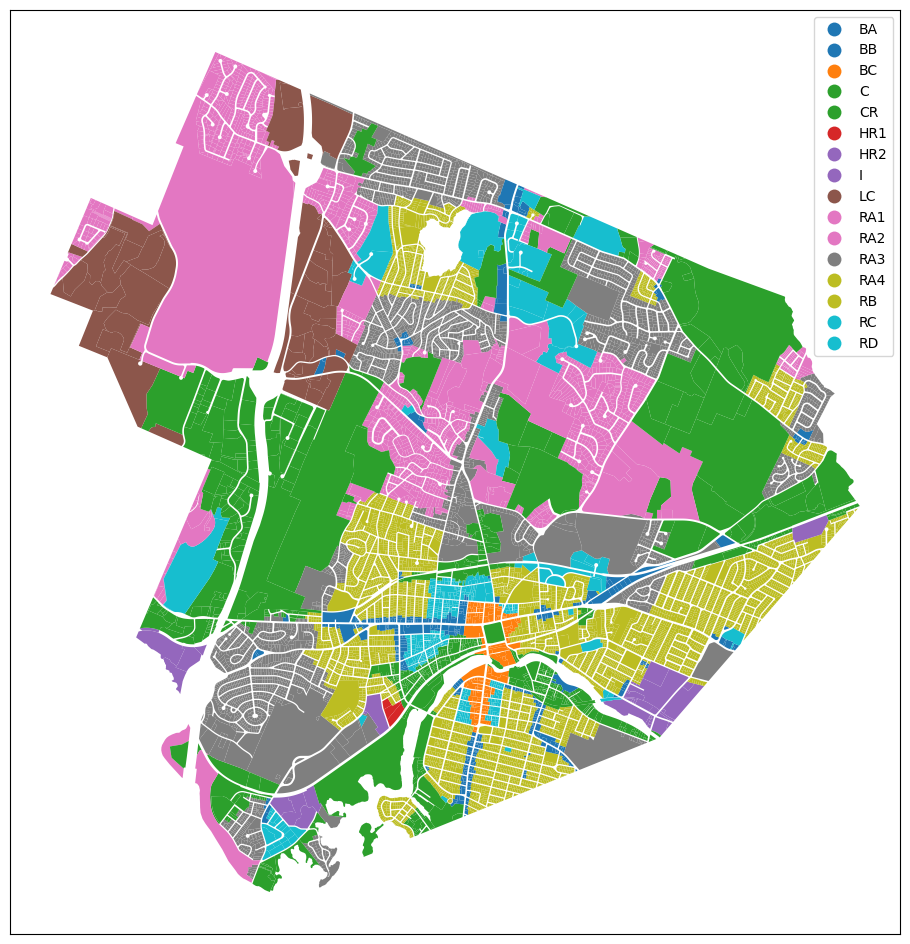

In [12]:
ax = zoned_parcels_df.plot(column="zone", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

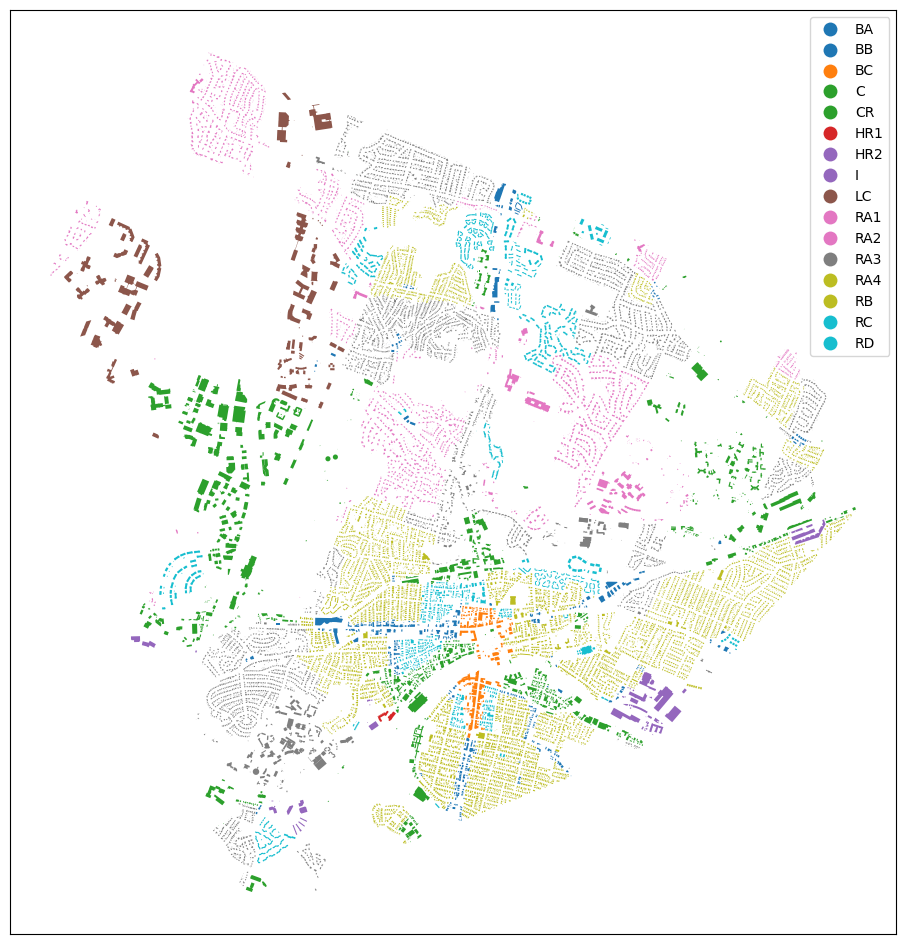

In [13]:
ax = zoned_buildings_df.plot(column="zone", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Non-compliance

Parcels might not comply if they're too small. Structures wouldn't comply based on their shape or closeness to each other. FAR and setback violations turn out to be pretty hard to calculate so we'll skip that for now.

In [14]:
zoned_parcels_df.head()

LOC_ID                                               geom zone  \
0  F_720118_2954451  MULTIPOLYGON (((219510.406 900516.563, 219505....  RA3   
1  F_720144_2954524  MULTIPOLYGON (((219521.229 900544.743, 219512....  RA3   
2  F_722474_2954539  MULTIPOLYGON (((220212.276 900527.633, 220199....  RA3   
3  F_720055_2954540  MULTIPOLYGON (((219481.807 900560.359, 219483....  RA3   
4  F_720183_2954604  MULTIPOLYGON (((219530.434 900568.770, 219524....  RA3   

   SHAPE_Area  
0    0.103024  
1    0.216257  
2    0.102640  
3    0.265953  
4    0.152051

In [15]:
zoned_parcels_df = zoned_parcels_df.merge(assessments_df, how="inner", on=["LOC_ID"])

In [16]:
zoned_parcels_df.head()

LOC_ID                                               geom zone  \
0  F_720118_2954451  MULTIPOLYGON (((219510.406 900516.563, 219505....  RA3   
1  F_720144_2954524  MULTIPOLYGON (((219521.229 900544.743, 219512....  RA3   
2  F_722474_2954539  MULTIPOLYGON (((220212.276 900527.633, 220199....  RA3   
3  F_720055_2954540  MULTIPOLYGON (((219481.807 900560.359, 219483....  RA3   
4  F_720183_2954604  MULTIPOLYGON (((219530.434 900568.770, 219524....  RA3   

   SHAPE_Area            SITE_ADDR  YEAR_BUILT  UNITS  RES_AREA STORIES  \
0    0.103024        759  SOUTH ST        1975      1      1612       2   
1    0.216257     753 -55 SOUTH ST        1860      2      5678       3   
2    0.102640  72 LOT EDGEWATER DR           0      0         0    None   
3    0.265953        757  SOUTH ST        1975      1       960       1   
4    0.152051        749  SOUTH ST        1960      1      1517       2   

   USE_CODE  BLD_AREA  assumed_height  
0       101      1612          8.5344  
1       104      5678         12.8016  
2       132         0          0.0000  
3       101       960          4.2672  
4       101      1517          8.5344

### Parcel size

Some zones have a minimum parcel size requirement.

In [17]:
def parcel_size(row):
    """
    returns True if the
    parcel is too small,
    False if there's no requirement
    or parcel is large enough
    """
    zone = row["zone"]
    min_lot_size = zoning_rules_df.at[zone, "lot area"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if min_lot_size == float('nan'):
        return False
    elif row["SHAPE_Area"] == float('nan') or row["SHAPE_Area"] == 0:
        return False
    
    return (row["SHAPE_Area"] * SQ_FT_PER_ACRE < min_lot_size)

zoned_parcels_df["parcel_size"] = zoned_parcels_df.apply(lambda row: parcel_size(row), axis="columns")

In [18]:
zoned_parcels_df["parcel_size"].value_counts()

parcel_size
False    8944
True     7564
Name: count, dtype: int64

Text(0.5, 1.0, 'parcels is too small')

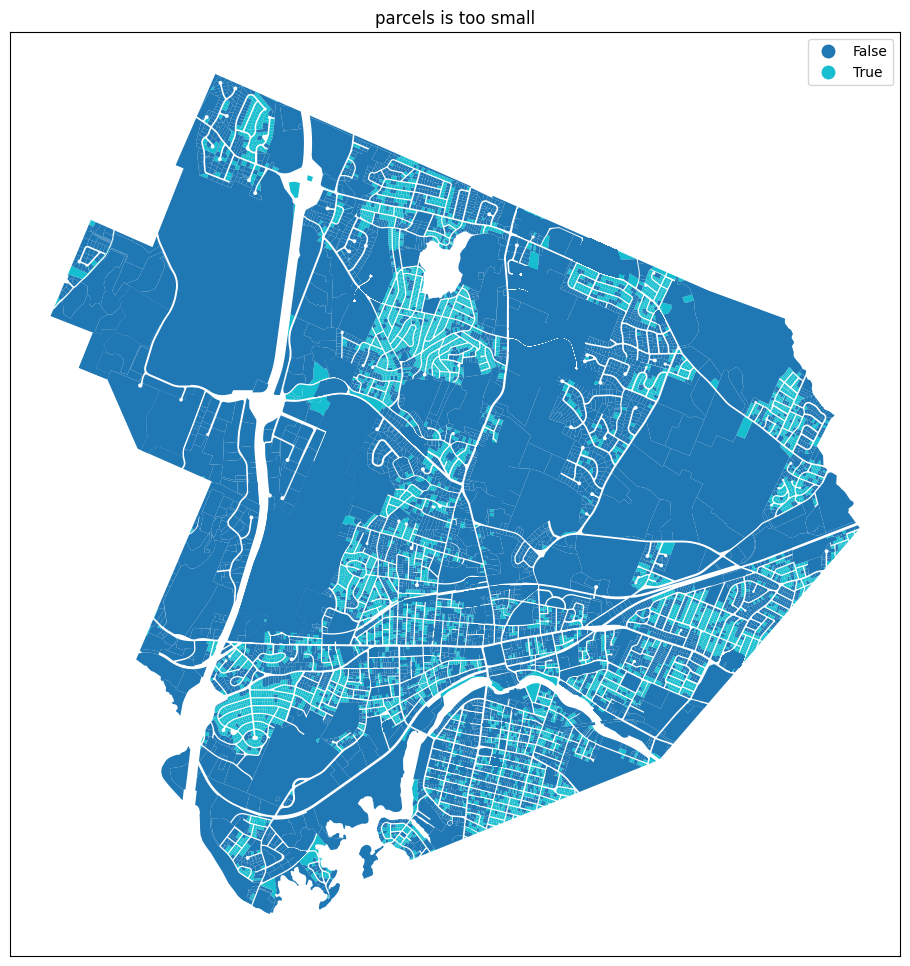

In [19]:
ax = zoned_parcels_df.plot(column="parcel_size", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title("parcels is too small")

### Too many STORIES

Because there's a shadow on my cucumber garden at 6:50 am in November

In [20]:
zoned_parcels_df

LOC_ID                                               geom  \
0      F_720118_2954451  MULTIPOLYGON (((219510.406 900516.563, 219505....   
1      F_720144_2954524  MULTIPOLYGON (((219521.229 900544.743, 219512....   
2      F_722474_2954539  MULTIPOLYGON (((220212.276 900527.633, 220199....   
3      F_720055_2954540  MULTIPOLYGON (((219481.807 900560.359, 219483....   
4      F_720183_2954604  MULTIPOLYGON (((219530.434 900568.770, 219524....   
...                 ...                                                ...   
16503  F_719877_2961772  MULTIPOLYGON (((219425.636 902734.138, 219402....   
16504  F_736247_2969777  MULTIPOLYGON (((224425.142 905189.026, 224420....   
16505  F_724665_2970529  MULTIPOLYGON (((220895.671 905409.290, 220859....   
16506  F_731940_2972635  MULTIPOLYGON (((223107.742 906048.523, 223078....   
16507  F_731747_2973216  MULTIPOLYGON (((223019.044 906229.286, 223019....   

      zone  SHAPE_Area            SITE_ADDR  YEAR_BUILT  UNITS  RES_AREA  \
0      RA3    0.103024        759  SOUTH ST        1975      1      1612   
1      RA3    0.216257     753 -55 SOUTH ST        1860      2      5678   
2      RA3    0.102640  72 LOT EDGEWATER DR           0      0         0   
3      RA3    0.265953        757  SOUTH ST        1975      1       960   
4      RA3    0.152051        749  SOUTH ST        1960      1      1517   
...    ...         ...                  ...         ...    ...       ...   
16503  RA3    0.115919     9  DORCHESTER ST        2020      1      2952   
16504  RA4    0.093597      19  ARCADIA AVE        2020      1      2880   
16505  RA3    0.131669      318  LINCOLN ST        2020      1      3374   
16506  RA4    0.116809        39  CIRCLE DR        2020      1      3592   
16507  RA3    0.171666      706  TRAPELO RD        1930      1      2640   

      STORIES  USE_CODE  BLD_AREA  assumed_height  parcel_size  
0           2       101      1612          8.5344         True  
1           3       104      5678         12.8016         True  
2        None       132         0          0.0000         True  
3           1       101       960          4.2672        False  
4           2       101      1517          8.5344         True  
...       ...       ...       ...             ...          ...  
16503       2       101      2952          8.5344         True  
16504       2       101      2880          8.5344         True  
16505       2       101      3374          8.5344         True  
16506       2       101      3592          8.5344         True  
16507       1       101      2640          4.2672         True  

[16508 rows x 13 columns]

In [21]:
def STORIES_high(row):
    """
    returns True if the
    structure on the parcel
    has too many STORIES,
    False if there's no requirement
    """
    zone = row["zone"]
    STORIES = zoning_rules_df.at[zone, "stories"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if STORIES == float('nan') or STORIES == "":
        return False
    elif row["STORIES"] == float('nan') or row["STORIES"] == "" or not row["STORIES"]:
        return False

    return (float(row["STORIES"]) > float(STORIES))

zoned_parcels_df["STORIES_high"] = zoned_parcels_df.apply(lambda row: STORIES_high(row), axis=1)

In [22]:
zoned_parcels_df["STORIES_high"].value_counts()

STORIES_high
False    16268
True       240
Name: count, dtype: int64

Text(0.5, 1.0, 'built structure has too many STORIES')

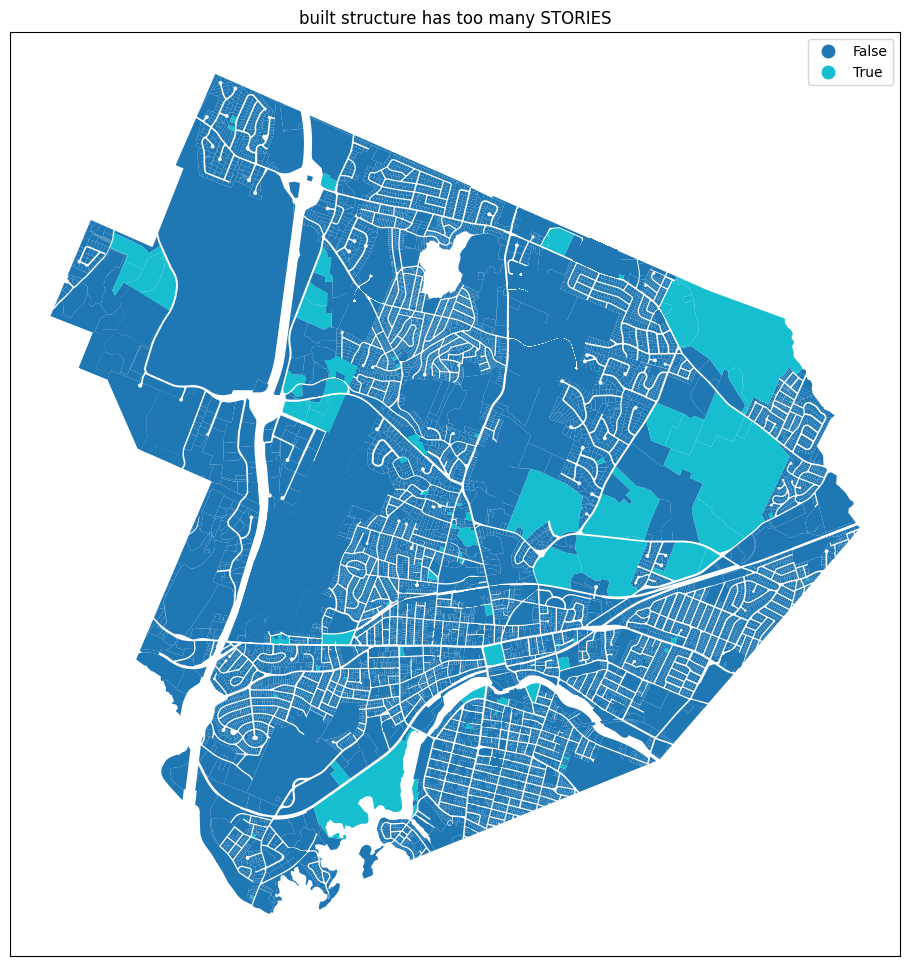

In [23]:
ax = zoned_parcels_df.plot(column="STORIES_high", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title("built structure has too many STORIES")

### Dwelling units per acre too high
Too many housing units in an acre

In [24]:
def too_many_units_per_acre(row):
    """
    returns True if the parcel has
    too many units / acre, for
    residential use codes
    """

    # residential use codes
    if int(row["USE_CODE"]) not in range(100, 200):
        return False

    zone = row["zone"]
    max_dua = zoning_rules_df.at[zone, "max DUA"]
    as_built_units = row["UNITS"]
    lot_size = row["SHAPE_Area"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if pd.isna(max_dua) or max_dua == "":
        return False
    elif as_built_units == float('nan') or as_built_units == "" or lot_size == 0:
        return False

    return as_built_units / lot_size > max_dua

zoned_parcels_df["too_many_units_per_acre"] = zoned_parcels_df.apply(lambda row: too_many_units_per_acre(row), axis=1)

In [25]:
zoned_parcels_df["too_many_units_per_acre"].value_counts()

too_many_units_per_acre
False    15872
True       636
Name: count, dtype: int64

Text(0.5, 1.0, 'too many units built on the parcel per acre')

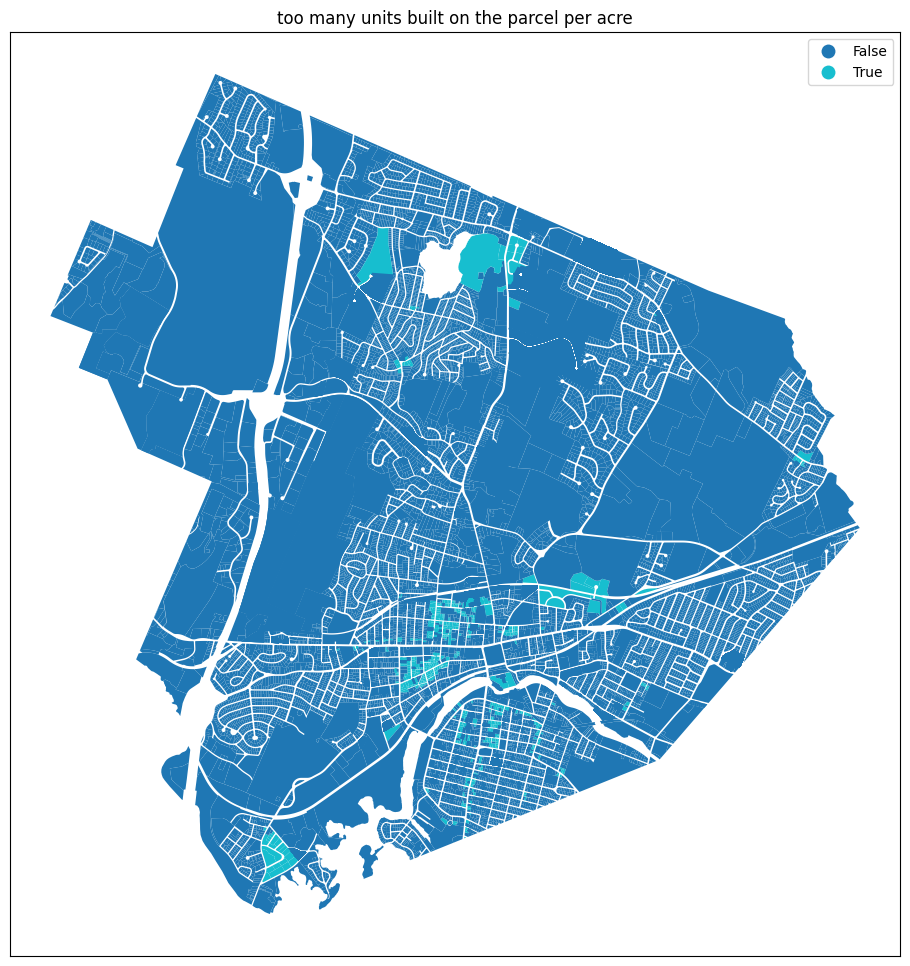

In [26]:
ax = zoned_parcels_df.plot(column="too_many_units_per_acre", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title("too many units built on the parcel per acre")

### Max lot coverage violations

IT'S A MONSTROSITY

I'm not too sure I have this correct, based on the interpretation of 'BLD_AREA'. Is it the sum total area (so adding the floors), or just the building footprint?

In [27]:
def lot_coverage_too_high(row):
    """
    returns True if the lot coverage
    of the built structure is
    higher than allowed
    """


    zone = row["zone"]
    max_lot_coverage = zoning_rules_df.at[zone, "max lot coverage"]
    bld_area = row["BLD_AREA"]
    lot_size = row["SHAPE_Area"]

    if pd.isna(max_lot_coverage) or max_lot_coverage == "":
        return False
    elif bld_area == float('nan') or bld_area == "":
        return False

    return bld_area > (lot_size * SQ_FT_PER_ACRE)

zoned_parcels_df["lot_coverage_too_high"] = zoned_parcels_df.apply(lambda row: lot_coverage_too_high(row), axis=1)

In [28]:
zoned_parcels_df["lot_coverage_too_high"].value_counts()

lot_coverage_too_high
False    16346
True       162
Name: count, dtype: int64

Text(0.5, 1.0, 'parcels where built structure lot coverage is too high')

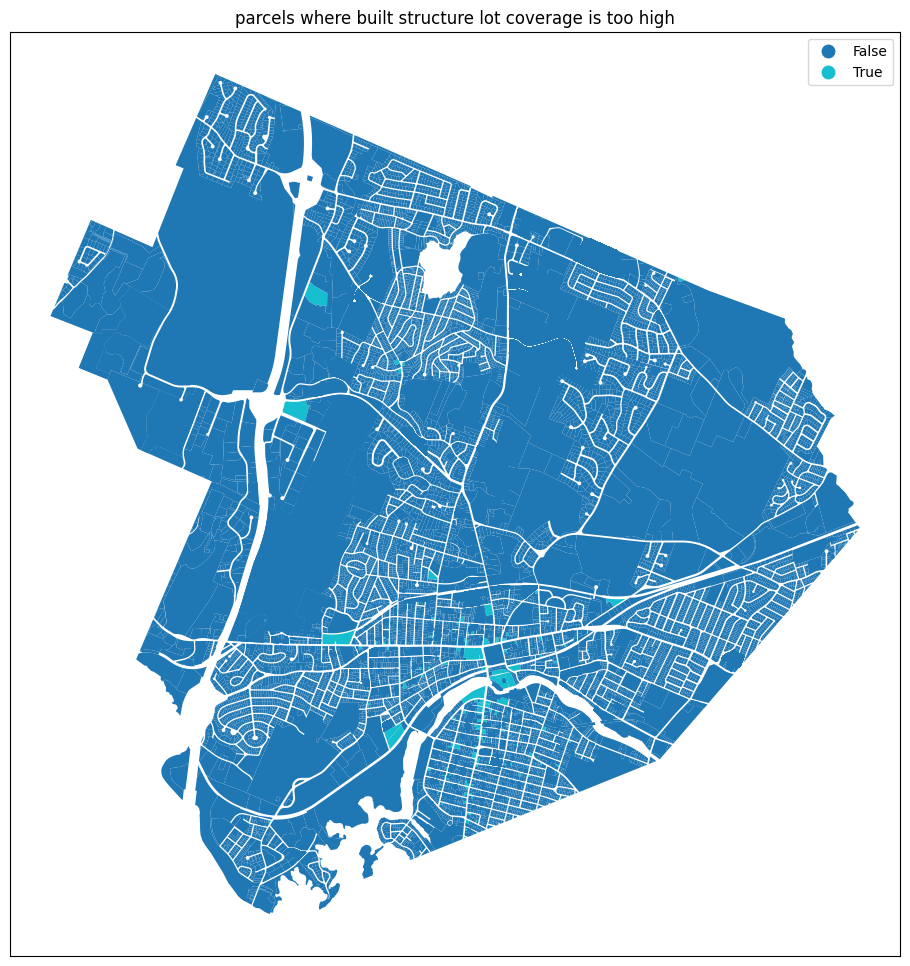

In [29]:
ax = zoned_parcels_df.plot(column="lot_coverage_too_high", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title("parcels where built structure lot coverage is too high")

### FAR violations

(floor area ratio, another way to discourage massing for some reason)

I'm not so sure I have this correct either.

In [30]:
def far_high(row):
    """
    returns True if the lot coverage
    of the built structure is
    higher than allowed
    """


    zone = row["zone"]
    far_limit = zoning_rules_df.at[zone, "FAR by right"]
    bld_area = row["BLD_AREA"]
    STORIES = row["STORIES"]
    lot_size = row["SHAPE_Area"] * SQ_FT_PER_ACRE

    if pd.isna(far_limit) or far_limit in["", 0] or lot_size == 0:
        return {"far_high": False, "far": 0.0}
    elif bld_area in [float('nan'), ""] or STORIES in [float('nan'), "", None]:
        return {"far_high": False, "far": 0.0}

    far = (bld_area * float(STORIES) / lot_size)
    
    return {"far_high": far > far_limit, "far": far}

zoned_parcels_df[["far_high", "far"]] = zoned_parcels_df.apply(lambda row: far_high(row), axis='columns', result_type='expand')

In [31]:
zoned_parcels_df["far_high"].value_counts()

far_high
False    14959
True      1549
Name: count, dtype: int64

<Axes: xlabel='far', ylabel='Count'>

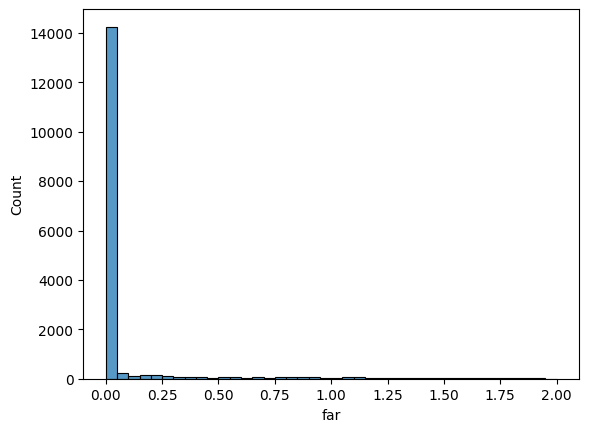

In [32]:
sns.histplot(zoned_parcels_df["far"], binrange=[0.0, 2.0], binwidth=0.05)

Text(0.5, 1.0, 'structures with too high floor area ratio')

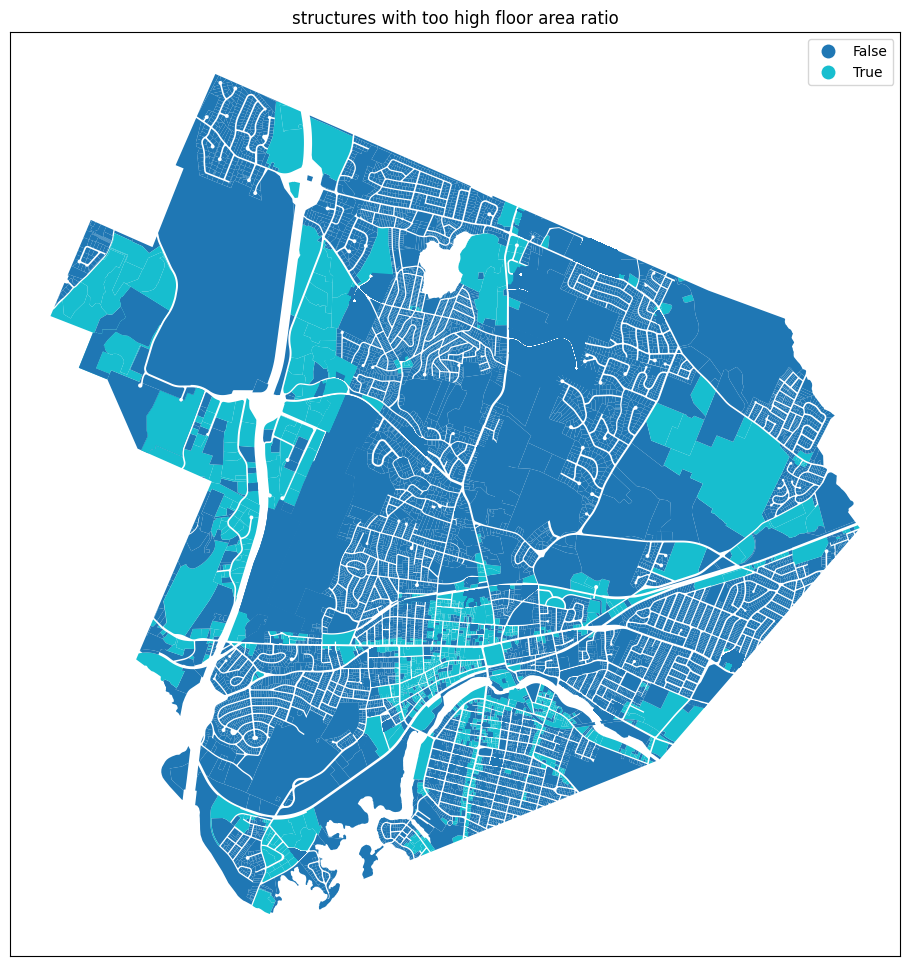

In [33]:
ax = zoned_parcels_df.plot(column="far_high", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title("structures with too high floor area ratio")

## All parcels that are illegal
(any combination of zoning violations, except for some building shape violations like FAR, lot coverage, or setbacks which aren't easy to calculate accurately)

In [34]:
def any_violations(row):
    "returns True for any violation"
    
    return row["parcel_size"] or row["STORIES_high"] or row["too_many_units_per_acre"]

zoned_parcels_df["any_violations"] = zoned_parcels_df.apply(lambda row: any_violations(row), axis=1, result_type='expand')

In [35]:
zoned_parcels_df["any_violations"].value_counts()

any_violations
False    8453
True     8055
Name: count, dtype: int64

Text(0.5, 1.0, 'parcels with at least one violation')

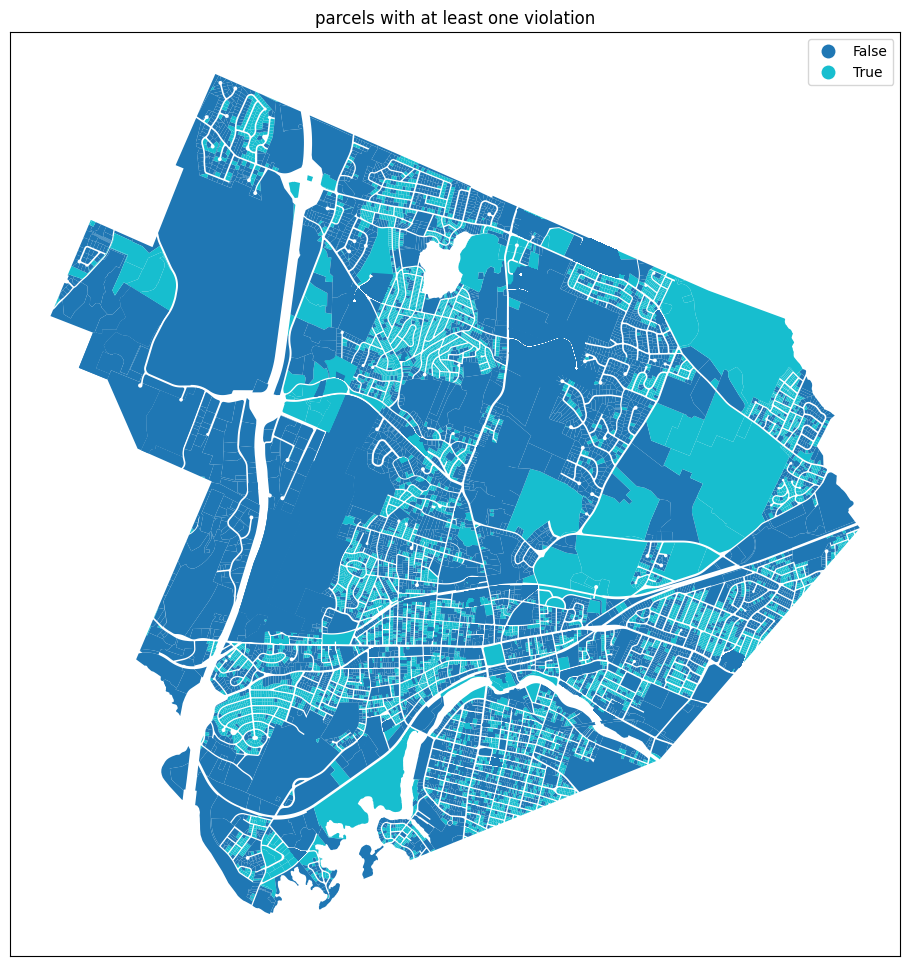

In [36]:
ax = zoned_parcels_df.plot(column="any_violations", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title("parcels with at least one violation")


#### Violations by year built

(TODO: This needs some more thought)

What is the real character of the city? The older structures, or the newer ones?
Of course you would expect that newer structures would be more likely to be acceptable (since that was the whole point of the zoning),
but if you didn't have any bias against the older stock, you would have incorporated into the zoning code.

<Axes: xlabel='YEAR_BUILT', ylabel='any_violations'>

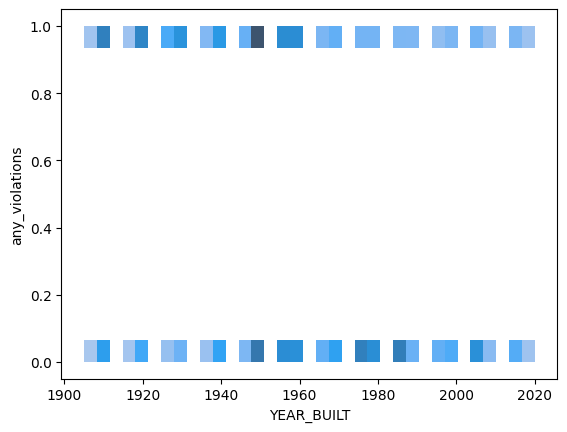

In [37]:
sns.histplot(zoned_parcels_df[zoned_parcels_df["YEAR_BUILT"] > 1900], x="YEAR_BUILT", y="any_violations")

Text(0.5, 1.0, 'parcels with at least one violation')

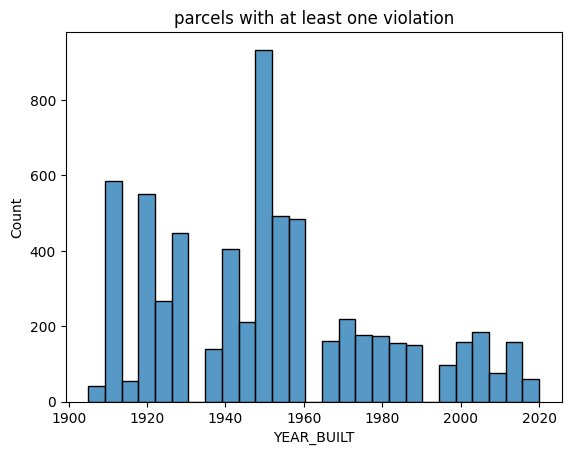

In [38]:
ax = sns.histplot(
    zoned_parcels_df[
        (zoned_parcels_df["YEAR_BUILT"] > 1900) & (zoned_parcels_df["any_violations"])
    ], 
    x="YEAR_BUILT"
)

ax.set_title("parcels with at least one violation")

Text(0.5, 1.0, 'parcels without violations')

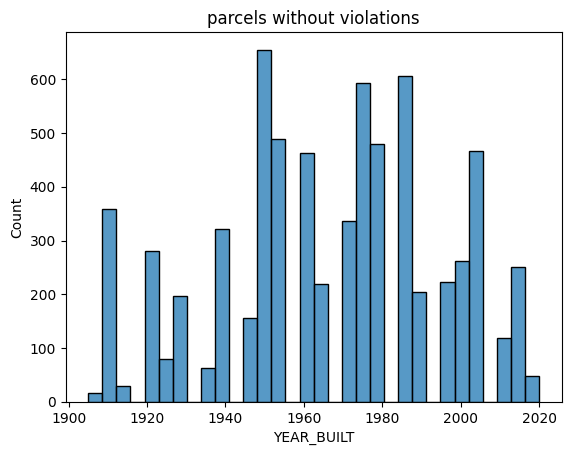

In [39]:
ax = sns.histplot(
    zoned_parcels_df[
        (zoned_parcels_df["YEAR_BUILT"] > 1900) & (~zoned_parcels_df["any_violations"])
    ], 
    x="YEAR_BUILT"
)

ax.set_title("parcels without violations")

#### Violations weighted by units built (i.e. units in parcels that have residential uses)

Not sure if I'm capturing this the best way. Seaborn doesn't let you weight 2d histograms (or I haven't yet figured out how), so I made a record for every unit. It doesn't
quite separate SFH from MFH though in this view.

<Axes: xlabel='YEAR_BUILT', ylabel='any_violations'>

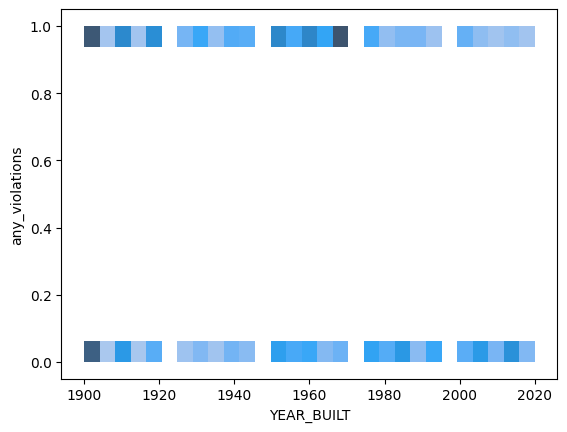

In [40]:
# there must be a better way to do this

units_weighted = []
for index in range(len(zoned_parcels_df)):
    if int(zoned_parcels_df.at[index, "USE_CODE"]) > 200 or int(zoned_parcels_df.at[index, "YEAR_BUILT"]) < 1900:
        continue
    
    for _ in range(zoned_parcels_df.at[index, "UNITS"]):
        units_weighted.append({
            "YEAR_BUILT": zoned_parcels_df.at[index, "YEAR_BUILT"],
            "any_violations": zoned_parcels_df.at[index, "any_violations"]
        })

df = pd.DataFrame(units_weighted)

sns.histplot(
    df,
    x="YEAR_BUILT",
    y="any_violations"
)

Text(0.5, 1.0, 'units in parcels with violations')

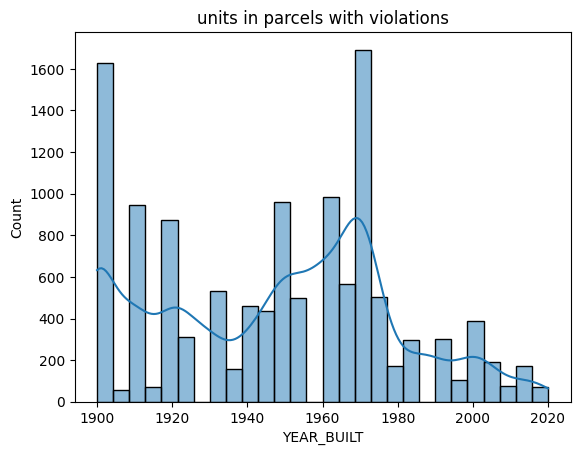

In [41]:
ax = sns.histplot(
    df[df["any_violations"]], 
    x="YEAR_BUILT",
    kde=True
)

ax.set_title("units in parcels with violations")

Text(0.5, 1.0, 'units in parcels without violations')

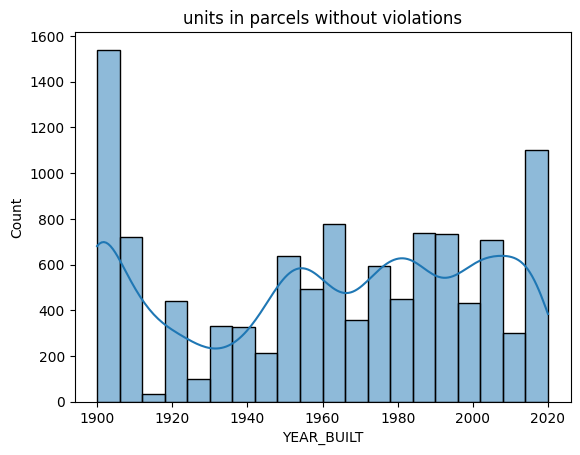

In [42]:
ax = sns.histplot(
    df[~df["any_violations"]], 
    x="YEAR_BUILT",
    kde=True
)

ax.set_title("units in parcels without violations")

In [43]:
#zoned_parcels_df["geom"] = zoned_parcels_df["geom"].explode()
zoned_parcels_df.to_postgis("illegal_zoning", con, if_exists="replace")

In [44]:
# prepare for mapping by converting to a lat/lon CRS
zoned_parcels_df.to_crs("EPSG:4326", inplace=True)

# purge some unneeded columns
map_df = zoned_parcels_df[["geom", "SITE_ADDR", "STORIES_high", "too_many_units_per_acre", "parcel_size", "any_violations"]]

In [45]:
center = [42.3, -71.2]
bounds = map_df.total_bounds.tolist()
m = folium.Map(
    location=center,
    zoom_start=10,
    tiles="cartodbpositron",
    max_bounds=True,
    max_width=800,
)

# TODO:
# is there anyway to restrict the actual panning bounds of the map?
m.fit_bounds([bounds[:2][::-1], bounds[2:][::-1]])

tooltip = folium.GeoJsonTooltip(
    fields=[
        "SITE_ADDR",
        "parcel_size",
        "STORIES_high",
        "too_many_units_per_acre",
    ],
    aliases=[
        "Address",
        "Parcel is too small",
        "Too many STORIES",
        "Too many units on parcel",
    ],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    min_zoom=2,
)


def fill_rule(feature):
    return {
        "fillColor": "red" if feature["properties"]["any_violations"] == 1 else "green",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.2,
    }


folium.GeoJson(
    map_df, style_function=lambda feature: fill_rule(feature), tooltip=tooltip
).add_to(m)

In [46]:

# uncomment to show - usually makes the file too big to show in github though
#m

In [47]:
os.makedirs("html", exist_ok=True)
m.save("html/illegal_zoning.html", bounds=(bounds[:2][::-1] + bounds[2:][::-1]), maxBoundsViscosity=1.0)